Jupyter Notebook

In [1]:
from src import *

In [2]:
#Initial Parameters
t_obs, x_obs, y_obs = load_data('data/predator-prey-data.csv')
init_cond = [x_obs[0], y_obs[0]]

init_guess = (1.0, 0.5, 1.5, 1.0)
bounds = [(0, 2), (0, 2), (0, 2), (0, 2)]

Optimization Functions - Global and Local 

c:\Users\magggien\anaconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


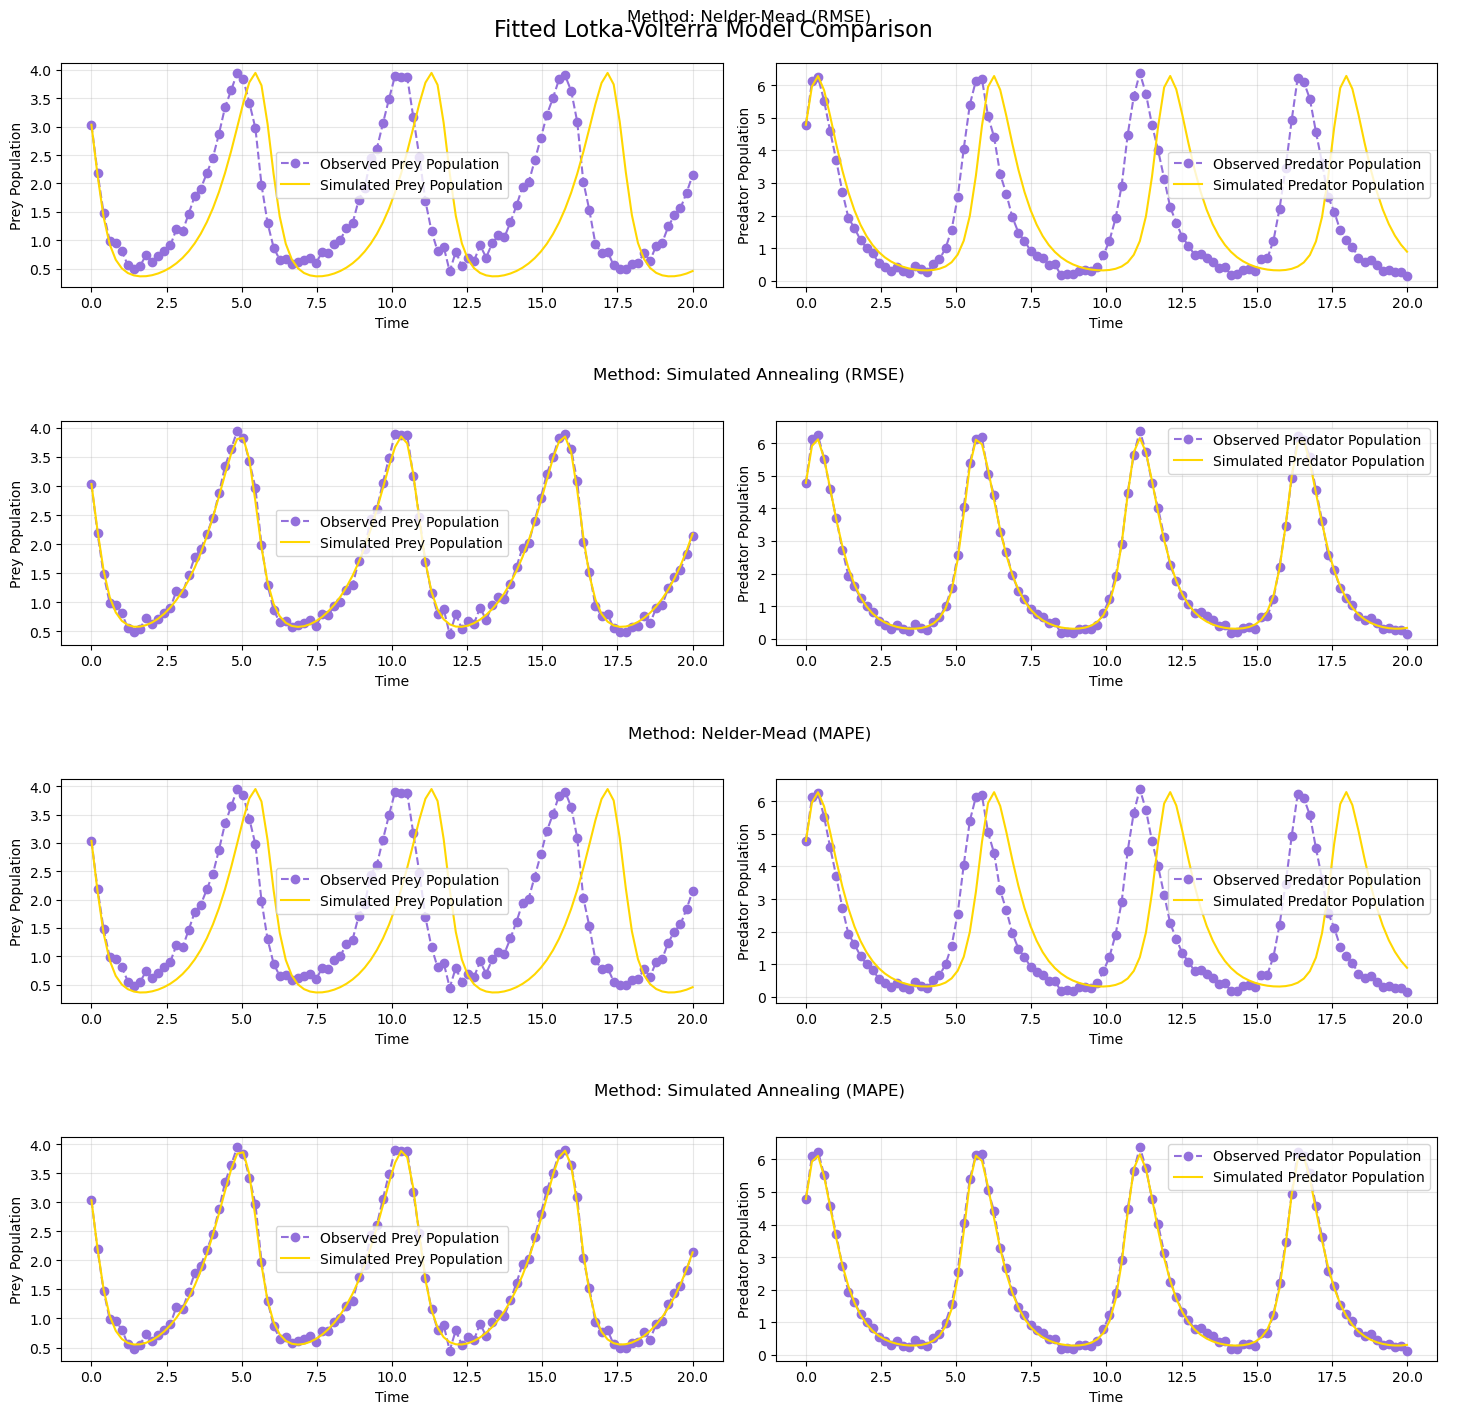


Parameters for Nelder-Mead (RMSE):
[1.  0.5 1.5 1. ]

Parameters for Simulated Annealing (RMSE):
[0.85987211 0.43969729 2.         1.15808812]

Parameters for Nelder-Mead (MAPE):
[1.  0.5 1.5 1. ]

Parameters for Simulated Annealing (MAPE):
[0.86925781 0.45357974 1.99722514 1.16974815]


In [20]:
# Run all optimizations and simulations
optimized_params_local_RMSE = local_optimization_RMSE(init_guess, bounds, t_obs, init_cond, x_obs, y_obs)
optimized_params_global_RMSE = global_optimization_RMSE(bounds, t_obs, init_cond, x_obs, y_obs)
optimized_params_local_MAPE = local_optimization_MAPE(init_guess, bounds, t_obs, init_cond, x_obs, y_obs)
optimized_params_global_MAPE = global_optimization_MAPE(bounds, t_obs, init_cond, x_obs, y_obs)

sim_data_local_RMSE = simulate_model(optimized_params_local_RMSE, init_cond, t_obs)
sim_data_global_RMSE = simulate_model(optimized_params_global_RMSE, init_cond, t_obs)
sim_data_local_MAPE = simulate_model(optimized_params_local_MAPE, init_cond, t_obs)
sim_data_global_MAPE = simulate_model(optimized_params_global_MAPE, init_cond, t_obs)

# Create the main figure
fig = plt.figure(figsize=(15, 15))

# Add a main title to the figure
fig.suptitle("Fitted Lotka-Volterra Model Comparison", fontsize=16, y=0.95)

# Create subplots for each method
methods = [
    ("Nelder-Mead (RMSE)", sim_data_local_RMSE),
    ("Simulated Annealing (RMSE)", sim_data_global_RMSE),
    ("Nelder-Mead (MAPE)", sim_data_local_MAPE),
    ("Simulated Annealing (MAPE)", sim_data_global_MAPE)
]

# Create a grid of subplots (2x2)
for i, (method, sim_data) in enumerate(methods):
    # Create two subplots side by side for each method
    ax1 = plt.subplot(4, 2, 2*i + 1)  # Left subplot (prey)
    ax2 = plt.subplot(4, 2, 2*i + 2)  # Right subplot (predator)
    
    plot_diffs_subplot(ax1, ax2, method, t_obs, x_obs, y_obs, 
                      sim_data[0], sim_data[1])
    
    # Add method title centered above both plots
    fig.add_subplot(4, 1, i+1, frameon=False)  # Create an invisible subplot spanning both columns
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)  # Make it invisible
    plt.title(f"Method: {method}", pad=30)

plt.tight_layout()
# Adjust layout to make room for the main title
plt.subplots_adjust(top=0.92)
plt.show()

# Print optimized parameters
for method, params in zip(methods, [optimized_params_local_RMSE, 
                                  optimized_params_global_RMSE,
                                  optimized_params_local_MAPE, 
                                  optimized_params_global_MAPE]):
    print(f"\nParameters for {method[0]}:")
    print(params)

## Experiments

Experiment with the number of data-points necessary for getting accurate result.

How many data-points from each time-series you could remove until you are not
able to reverse-engineer the parameters any more?
* First, try to find the importance of each time-series on reverse-engineering
process by fixing one time-series and removing data-points from the other
one. In this way, you will find the critical number of data-points for each
time-series.
* Then, if you combine two reduced time-series, could you still infer the pa-
rameters?
* Does removing every data-point have the same effect on reverse-
engineering process? In other words, what are the points that you
could remove safely without affecting the inferance procedure? and what
are those with critical effects on the process?
2


Starting predator deletion analysis at 01:35:25

Scenario 1/8: Removing 20 points...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   39.1s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   39.6s remaining:   39.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   40.6s remaining:   17.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   41.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Trial results for 20 points removed:
Parameter values across trials:
α values: [0.86162431 0.86163412 0.86163471 0.86163502 0.86163477 0.86162096
 0.86163547 0.8616311  0.86163219 0.8616344 ]
β values: [0.44035416 0.44036216 0.44036171 0.44036194 0.44036219 0.44035827
 0.44036273 0.44036073 0.44036154 0.44036199]
γ values: [1.99588716 1.9958755  1.99587357 1.99587202 1.99587334 1.9959122
 1.99587194 1.99587984 1.99587791 1.99587386]
δ values: [1.15569612 1.15570005 1.15569939 1.15569731 1.15569872 1.1557213
 1.15569785 1.15569915 1.15569764 1.15569845]

Optimized parameters:
- α: 0.8616 ± 0.0000
- β: 0.4404 ± 0.0000
- γ: 1.9959 ± 0.0000
- δ: 1.1557 ± 0.0000

Scenario 2/8: Removing 40 points...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   35.9s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   36.4s remaining:   36.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   37.4s remaining:   16.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   38.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Trial results for 40 points removed:
Parameter values across trials:
α values: [0.85932315 0.85932313 0.85932308 0.85932149 0.86786675 0.85931663
 0.85932314 0.86795028 0.8593231  0.85932312]
β values: [0.43920082 0.43920069 0.43920064 0.43919509 0.44283017 0.4391872
 0.43920071 0.44280201 0.43920067 0.43920069]
γ values: [2.         2.         2.         2.         1.9795733  2.
 2.         1.98141289 2.         2.        ]
δ values: [1.15651337 1.15651354 1.15651341 1.1565163  1.14706291 1.15650954
 1.15651352 1.15079334 1.15651344 1.15651348]

Optimized parameters:
- α: 0.8610 ± 0.0026
- β: 0.4399 ± 0.0011
- γ: 1.9961 ± 0.0059
- δ: 1.1550 ± 0.0024

Scenario 3/8: Removing 60 points...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   33.6s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   34.3s remaining:   34.3s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   34.8s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   36.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Trial results for 60 points removed:
Parameter values across trials:
α values: [0.85650135 0.93087919 0.86068587 0.85650117 0.85650129 0.85650112
 0.85650155 0.85650141 0.85650155 0.85650138]
β values: [0.43887697 0.47240778 0.44028176 0.43887665 0.43887693 0.43887675
 0.4388771  0.43887702 0.43887725 0.43887702]
γ values: [2.         1.8460181  1.99030926 2.         2.         2.
 2.         2.         2.         2.        ]
δ values: [1.14839694 1.09573114 1.14505492 1.14839674 1.14839675 1.14839638
 1.14839742 1.14839711 1.14839729 1.14839697]

Optimized parameters:
- α: 0.8644 ± 0.0167
- β: 0.4424 ± 0.0076
- γ: 1.9836 ± 0.0347
- δ: 1.1428 ± 0.0119

Scenario 4/8: Removing 80 points...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   34.7s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   34.8s remaining:   34.8s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   35.6s remaining:   15.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   36.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Trial results for 80 points removed:
Parameter values across trials:
α values: [0.89560526 0.89586879 0.89551942 0.8951052  0.89556465 0.89531507
 0.89526559 0.89521161 0.89524213 0.89535664]
β values: [0.46133538 0.46151316 0.46131985 0.46116053 0.46134284 0.46120485
 0.46118833 0.46118778 0.46120205 0.46125051]
γ values: [1.91561397 1.91528129 1.91598837 1.91686898 1.91580087 1.91629007
 1.91647076 1.91655826 1.91650991 1.91629801]
δ values: [1.1075235  1.10759624 1.10790144 1.10825455 1.10769988 1.10789108
 1.10806427 1.10802474 1.10803459 1.10798234]

Optimized parameters:
- α: 0.8954 ± 0.0002
- β: 0.4613 ± 0.0001
- γ: 1.9162 ± 0.0003
- δ: 1.1079 ± 0.0002

Scenario 5/8: Removing 85 points...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   33.1s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   33.3s remaining:   33.3s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   33.9s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   34.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Trial results for 85 points removed:
Parameter values across trials:
α values: [0.85642058 0.85642059 0.8564206  0.85642078 0.8564205  0.8564206
 0.85642075 0.85642029 0.85642076 0.8564206 ]
β values: [0.44016185 0.44016189 0.44016187 0.44016204 0.44016182 0.44016187
 0.44016234 0.44016324 0.4401621  0.44016186]
γ values: [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
δ values: [1.14693414 1.14693421 1.14693422 1.14693474 1.14693319 1.14693426
 1.14693471 1.14693086 1.1469345  1.14693426]

Optimized parameters:
- α: 0.8564 ± 0.0000
- β: 0.4402 ± 0.0000
- γ: 2.0000 ± 0.0000
- δ: 1.1469 ± 0.0000

Scenario 6/8: Removing 88 points...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   33.3s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   33.7s remaining:   33.7s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   33.8s remaining:   14.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   35.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Trial results for 88 points removed:
Parameter values across trials:
α values: [0.85480397 0.85480359 0.85480353 0.85480361 0.85480356 0.85543139
 0.85480358 0.85480277 0.8548036  0.85596702]
β values: [0.43706097 0.4370605  0.43706042 0.43706051 0.43706048 0.43728336
 0.43706051 0.43705988 0.43706052 0.43761848]
γ values: [2.         2.         2.         2.         2.         1.99824624
 2.         2.         2.         1.99603656]
δ values: [1.14199087 1.14199012 1.14199001 1.14199017 1.14199004 1.14097206
 1.14199008 1.14198799 1.14199013 1.1386796 ]

Optimized parameters:
- α: 0.8550 ± 0.0003
- β: 0.4371 ± 0.0001
- γ: 1.9994 ± 0.0009
- δ: 1.1416 ± 0.0008

Scenario 7/8: Removing 90 points...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   32.9s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   33.4s remaining:   33.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   34.0s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   34.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Trial results for 90 points removed:
Parameter values across trials:
α values: [0.90749033 0.90749674 0.90748694 0.9074873  0.9074891  0.90751106
 0.938935   0.907481   0.9074925  0.90748999]
β values: [0.46377325 0.46377536 0.46377115 0.46375189 0.46376845 0.46378357
 0.48044112 0.4637675  0.46377308 0.46377233]
γ values: [1.90384937 1.90383323 1.90385389 1.90383349 1.90385103 1.90380852
 1.84208671 1.90386575 1.9038417  1.90384708]
δ values: [1.12408881 1.12407951 1.12408849 1.12408423 1.12409518 1.12407311
 1.09498413 1.12409465 1.12408304 1.12408504]

Optimized parameters:
- α: 0.9106 ± 0.0071
- β: 0.4654 ± 0.0038
- γ: 1.8977 ± 0.0140
- δ: 1.1212 ± 0.0066

Scenario 8/8: Removing 95 points...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   23.7s remaining:   55.5s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   24.0s remaining:   24.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   24.3s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   24.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Trial results for 95 points removed:
Parameter values across trials:
α values: [0.88758634 0.88757987 0.88754211 0.88754871 0.88756268 0.88755608
 0.88756288 0.88759228 0.88758357 0.88758953]
β values: [0.45229744 0.45229948 0.4522803  0.45228222 0.45229072 0.45229637
 0.45229432 0.45230414 0.4523018  0.45230399]
γ values: [1.92791686 1.92793427 1.9280106  1.92800336 1.92796764 1.92799775
 1.92798121 1.92789526 1.92792505 1.92790646]
δ values: [1.11012991 1.1101381  1.11016628 1.11017097 1.1101479  1.11016973
 1.11016425 1.11010962 1.1101304  1.11012047]

Optimized parameters:
- α: 0.8876 ± 0.0000
- β: 0.4523 ± 0.0000
- γ: 1.9280 ± 0.0000
- δ: 1.1101 ± 0.0000

Analysis complete for predator deletion!

Starting prey deletion analysis at 01:40:07

Scenario 1/8: Removing 20 points...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   34.0s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   35.0s remaining:   35.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   35.1s remaining:   15.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   35.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Trial results for 20 points removed:
Parameter values across trials:
α values: [0.86435705 0.8644302  0.86436774 0.86436261 0.86429658 0.86435757
 0.86435077 0.86435812 0.86436385 0.864376  ]
β values: [0.44337588 0.44347182 0.44338166 0.44337804 0.44335606 0.44337598
 0.44337314 0.44337627 0.44337935 0.44338476]
γ values: [1.99271126 1.99236454 1.99268897 1.9926972  1.99287062 1.99270972
 1.99272616 1.99270854 1.99269469 1.99266516]
δ values: [1.155927   1.15549992 1.15591911 1.15591944 1.15600787 1.15592601
 1.15593391 1.15592552 1.15591776 1.15590338]

Optimized parameters:
- α: 0.8644 ± 0.0000
- β: 0.4434 ± 0.0000
- γ: 1.9927 ± 0.0001
- δ: 1.1559 ± 0.0001

Scenario 2/8: Removing 40 points...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   34.7s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   34.8s remaining:   34.8s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   35.0s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   35.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Trial results for 40 points removed:
Parameter values across trials:
α values: [0.86486704 0.86486873 0.86486729 0.86486807 0.86486098 0.8648686
 0.86486822 0.86486816 0.86486783 0.86488533]
β values: [0.44450978 0.44451065 0.44450912 0.44451012 0.4445089  0.4445105
 0.4445103  0.44451022 0.44450985 0.44452072]
γ values: [1.99180607 1.99180186 1.99180204 1.99180362 1.99182955 1.99180281
 1.99180315 1.99180322 1.99180357 1.9917687 ]
δ values: [1.15414277 1.15414039 1.15413638 1.1541418  1.15416207 1.15414166
 1.15414124 1.15414128 1.15414129 1.1541302 ]

Optimized parameters:
- α: 0.8649 ± 0.0000
- β: 0.4445 ± 0.0000
- γ: 1.9918 ± 0.0000
- δ: 1.1541 ± 0.0000

Scenario 3/8: Removing 60 points...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   34.3s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   34.3s remaining:   34.3s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   34.5s remaining:   14.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   35.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Trial results for 60 points removed:
Parameter values across trials:
α values: [0.85670085 0.85670068 0.85651661 0.85670118 0.85670075 0.85669987
 0.85669924 0.85670037 0.85670066 0.85670081]
β values: [0.4329645  0.43296461 0.43261879 0.43296465 0.43296433 0.43296353
 0.43296315 0.43296406 0.43296428 0.43296463]
γ values: [2.         2.         1.99999932 2.         2.         2.
 2.         2.         2.         2.        ]
δ values: [1.1574252  1.1574238  1.15722736 1.1574257  1.15742451 1.15742236
 1.15742045 1.15742348 1.15742425 1.15742429]

Optimized parameters:
- α: 0.8567 ± 0.0000
- β: 0.4329 ± 0.0001
- γ: 2.0000 ± 0.0000
- δ: 1.1574 ± 0.0000

Scenario 4/8: Removing 80 points...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   36.2s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   36.6s remaining:   36.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   36.7s remaining:   15.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   37.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Trial results for 80 points removed:
Parameter values across trials:
α values: [0.86778958 0.86778938 0.86778993 0.86779017 0.86778892 0.9167471
 0.86779119 0.86778759 0.86778951 0.86778952]
β values: [0.44661896 0.44661892 0.44661909 0.44661929 0.44661874 0.46761358
 0.44661969 0.44661823 0.44661886 0.44661901]
γ values: [1.9929141  1.99291473 1.99291326 1.99291291 1.9929165  1.88200143
 1.99291538 1.99291811 1.99291415 1.99291457]
δ values: [1.17045536 1.17045575 1.17045496 1.17045495 1.17045717 1.112789
 1.17046186 1.1704565  1.17045578 1.17045582]

Optimized parameters:
- α: 0.8727 ± 0.0111
- β: 0.4487 ± 0.0047
- γ: 1.9818 ± 0.0251
- δ: 1.1647 ± 0.0130

Scenario 5/8: Removing 85 points...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   36.5s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   36.9s remaining:   36.9s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   37.4s remaining:   16.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   37.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Trial results for 85 points removed:
Parameter values across trials:
α values: [0.8968802  0.89688072 0.89688335 0.89688633 0.89689801 0.89688247
 0.89688151 0.89690453 0.89688624 0.89688889]
β values: [0.47142757 0.47142427 0.47142439 0.47142723 0.47143335 0.4714248
 0.47142462 0.47143822 0.47142724 0.47142862]
γ values: [1.92960838 1.92959835 1.92959352 1.92958511 1.92955749 1.92959067
 1.92959472 1.92955219 1.92958259 1.92958031]
δ values: [1.11773262 1.11772195 1.11772337 1.11771361 1.11769678 1.11771368
 1.1177174  1.11770254 1.11770936 1.11771195]

Optimized parameters:
- α: 0.8969 ± 0.0000
- β: 0.4714 ± 0.0000
- γ: 1.9296 ± 0.0000
- δ: 1.1177 ± 0.0000

Scenario 6/8: Removing 88 points...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   36.9s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   37.5s remaining:   37.5s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   37.5s remaining:   16.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   38.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Trial results for 88 points removed:
Parameter values across trials:
α values: [0.86533184 0.86533218 0.86533418 0.86533254 0.86533359 0.86533326
 0.86533322 0.86533327 0.86533245 0.86533228]
β values: [0.44209489 0.44209567 0.44209855 0.44209594 0.4420975  0.44209676
 0.44209679 0.44209706 0.44209578 0.442096  ]
γ values: [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
δ values: [1.17200105 1.17200115 1.17200434 1.17200228 1.17200353 1.17200351
 1.17200347 1.17200307 1.17200208 1.17200115]

Optimized parameters:
- α: 0.8653 ± 0.0000
- β: 0.4421 ± 0.0000
- γ: 2.0000 ± 0.0000
- δ: 1.1720 ± 0.0000

Scenario 7/8: Removing 90 points...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   28.3s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   28.7s remaining:   28.7s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   29.1s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   29.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Trial results for 90 points removed:
Parameter values across trials:
α values: [0.85153489 0.85109744 0.85109751 0.85110287 0.8510968  0.85109696
 0.86697765 0.85962341 0.85109728 0.8510972 ]
β values: [0.43104762 0.42947371 0.42947373 0.42946965 0.42947311 0.4294731
 0.43745104 0.43266796 0.42947341 0.42947345]
γ values: [1.99973702 2.         2.         2.         2.         2.
 1.96166914 1.98546042 2.         2.        ]
δ values: [1.14263271 1.14432931 1.14432962 1.14436163 1.14432781 1.14432838
 1.12341981 1.14810834 1.14432923 1.14432873]

Optimized parameters:
- α: 0.8536 ± 0.0039
- β: 0.4307 ± 0.0018
- γ: 1.9947 ± 0.0089
- δ: 1.1424 ± 0.0049

Scenario 8/8: Removing 95 points...


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   31.8s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   32.8s remaining:   32.8s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   33.1s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   33.5s finished



Trial results for 95 points removed:
Parameter values across trials:
α values: [0.87582073 0.8861787  0.88015283 0.87582068 0.87582064 0.87582003
 0.87581945 0.87581963 0.87582058 0.87582132]
β values: [0.46141282 0.46727527 0.4618174  0.46141265 0.46141268 0.46141226
 0.46141178 0.46141192 0.46141257 0.46141375]
γ values: [2.         1.98026735 1.99251864 2.         2.         2.
 2.         2.         2.         2.        ]
δ values: [1.18991532 1.18526395 1.19166763 1.18991535 1.18991517 1.18991351
 1.18991214 1.18991234 1.18991506 1.18991618]

Optimized parameters:
- α: 0.8773 ± 0.0024
- β: 0.4620 ± 0.0013
- γ: 1.9973 ± 0.0046
- δ: 1.1896 ± 0.0012

Analysis complete for prey deletion!


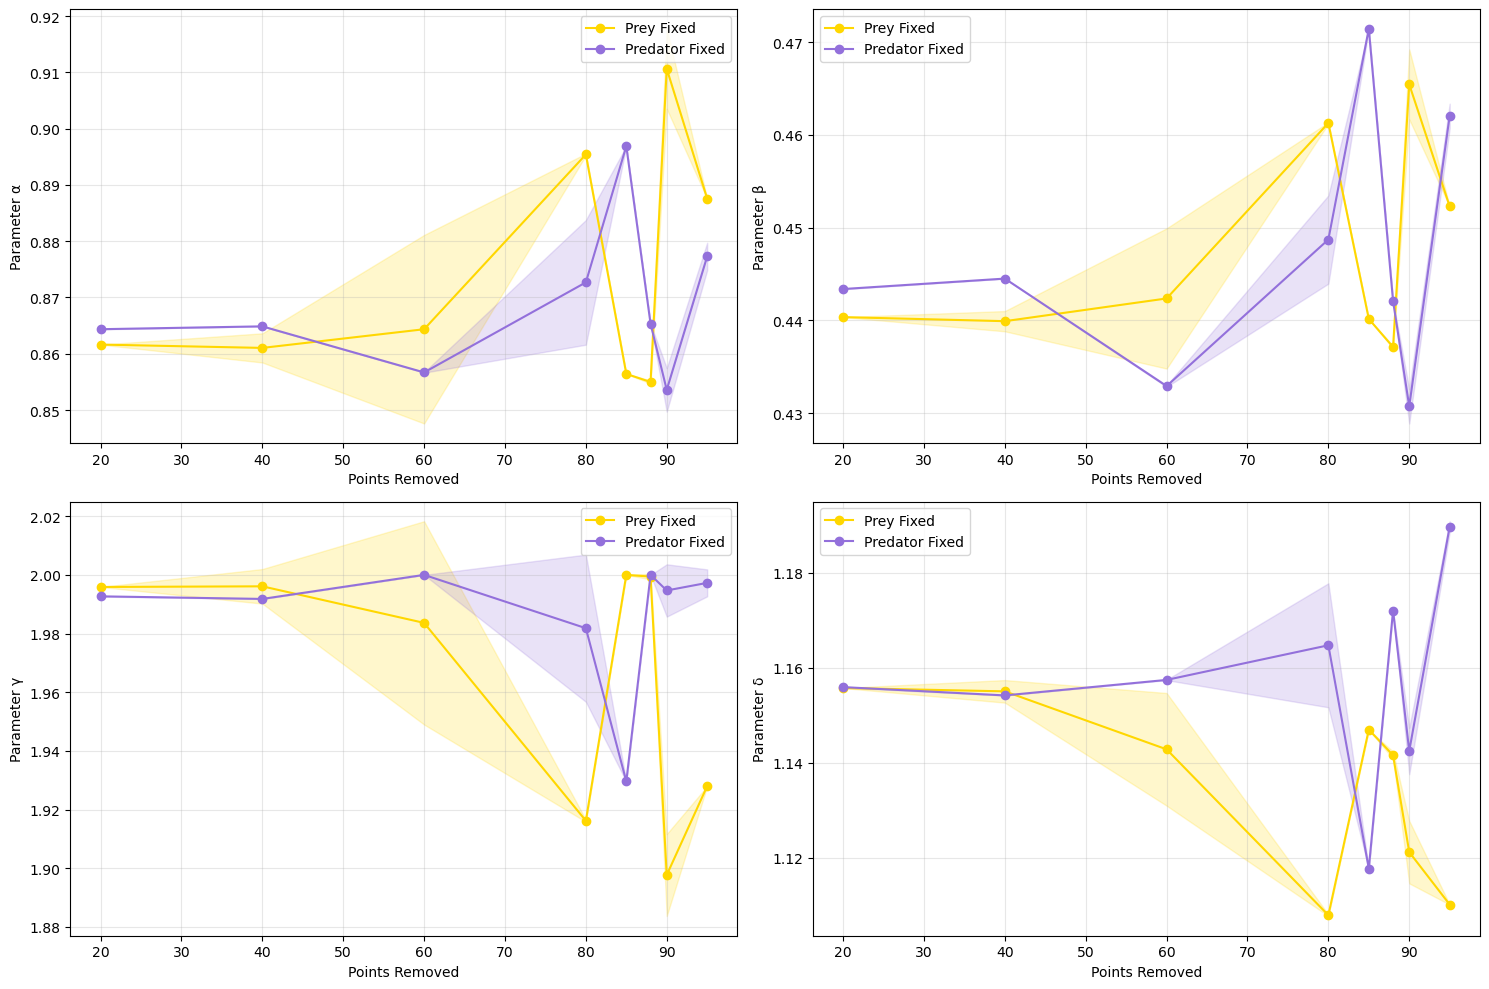

In [3]:
num_deletions = [20, 40, 60, 80, 85, 88, 90, 95]

# Run analyses
mean_params_Y, conf_params_Y = optimization_with_deletion(
    t_obs, x_obs, y_obs,
    init_cond,
    num_deletions,
    bounds,
    fix_prey=True
)

mean_params_X, conf_params_X = optimization_with_deletion(
    t_obs, x_obs, y_obs,
    init_cond,
    num_deletions,
    bounds,
    fix_prey=False
)

# Create results dictionary
results = {
    'prey_fixed': {'means': mean_params_Y, 'confs': conf_params_Y},
    'pred_fixed': {'means': mean_params_X, 'confs': conf_params_X},
    'num_deletions': num_deletions
}

# Plot results
plot_statistical_results(results)